#  Python Good/Bad Spectra Detection using Machine Learnig for R6G SERS Experiments
## Model Selection 

This notebook outlines the model selection for the experiments

## Setup 

Loading key packages

In [1]:
import sys 
sys.path.insert(0, "/ramanbox/")
import os
import git
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ramanbox.raman.sample_builder import SampleBuilder
from ramanbox.raman.sample import Sample
from ramanbox.raman.constants import Label
from fit_visualization import FittingVisualizer
from helper_funs import make_df, make_Xy
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
import copy

In [2]:
random.seed(42)

## Data Loading

Loading data into memory 

In [3]:
labeled_data_dir = 'data'
figure_directory = '../'

In [4]:
#load labeled data 
net_cdf_files = glob.glob(os.path.join(labeled_data_dir, '*.nc'))
sample_list = []
for file in net_cdf_files:
    sample_list.append(Sample.build_from_netcdf(file))

In [5]:
# store wavenumbers in variable 
wavenumbers = sample_list[0].spot_list[0].spectrum_list[0].wavenumbers

In [6]:
# print index and name of loaded samples 
print('Loaded Samples')
for index, sample in enumerate(sample_list):
    print(index, sample.name)

Loaded Samples
0 20200226_moxtek_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
1 20200226_moxtek_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure
2 20200226_plasmore_R6G_10^-5mM_60X_10mW_20x20_scan_1sec_exposure
3 20200226_plasmore_R6G_10^-5mM_60X_20mW_20x20_scan_1sec_exposure
4 20200226_plasmore_R6G_3mM_60X_10mW_20x20_scan_1sec_exposure


## Train Test Split

For the model selection portion, the samples for each experiment are mixed together. This in-sample prediction ability is the 

Now use the helper functions make_df and get_X_Y to generate training data, validation data and test data without the "maybe" labeled spectra. 

In [8]:
X, y = make_Xy(make_df(sample_list))

### Determine Class Fraction

In [9]:
print('Positive Fraction ', sum(y), '/' , len(y), "{:.2f}".format(sum(y)/len(y)*100), '%')
print('Negative Fraction ', len(y) - sum(y), '/' , len(y), "{:.2f}".format((len(y) -sum(y))/len(y)*100), '%' )

Positive Fraction  940 / 1876 50.11 %
Negative Fraction  936 / 1876 49.89 %


In [10]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train_m_val, X_val, y_train_m_val, y_val = train_test_split(X_train, y_train, test_size=0.15)

In [11]:
print("Train Data Set")
print('Positive Fraction ', sum(y_train), '/' , len(y_train), "{:.2f}".format(sum(y_train)/len(y_train)*100), '%')
print('Negative Fraction ', len(y_train) - sum(y_train), '/' , len(y_train), "{:.2f}".format((len(y_train) -sum(y_train))/len(y_train)*100), '%' )
print("Val Data Set")
print('Positive Fraction ', sum(y_val), '/' , len(y_val), "{:.2f}".format(sum(y_val)/len(y_val)*100), '%')
print('Negative Fraction ', len(y_val) - sum(y_val), '/' , len(y_val), "{:.2f}".format((len(y_val) -sum(y_val))/len(y_val)*100), '%' )
print("Test Data Set")
print('Positive Fraction ', sum(y_test), '/' , len(y_test), "{:.2f}".format(sum(y_val)/len(y_test)*100), '%')
print('Negative Fraction ', len(y_test) - sum(y_test), '/' , len(y_test), "{:.2f}".format((len(y_test) -sum(y_test))/len(y_test)*100), '%' )

Train Data Set
Positive Fraction  800 / 1594 50.19 %
Negative Fraction  794 / 1594 49.81 %
Val Data Set
Positive Fraction  116 / 240 48.33 %
Negative Fraction  124 / 240 51.67 %
Test Data Set
Positive Fraction  140 / 282 41.13 %
Negative Fraction  142 / 282 50.35 %


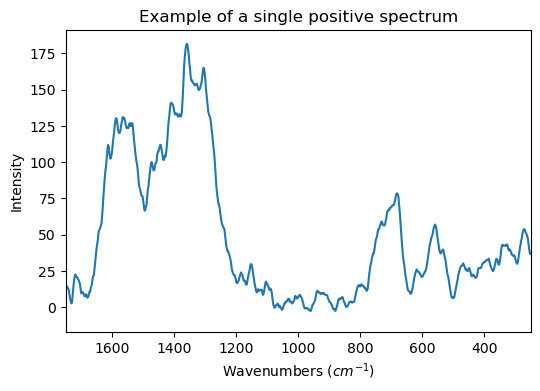

In [12]:
# Visualize first spectrum in train set
pos_index = 0
for i in range(0, len(y_train)):
    if y_train[i] == 1:
        pos_index = i
        
plt.figure(dpi=100)
plt.title("Example of a single positive spectrum")
plt.plot(wavenumbers, X_train[pos_index])
plt.xlim([1750, 250])
plt.xlabel("Wavenumbers $(cm^{-1})$")
plt.ylabel("Intensity")
plt.savefig(os.path.join(figure_directory, 'example_pos_spectrum.svg'))

****

## Select Hyperparamters for Models Using Grid Search

Model List
1. Stochastic Gradient Descent Classifier with a logistic regression loss function (LR-SGD) 
2. Stochastic Gradient Descent Classifier with a linear SVG loss function (SVG-SGD)
3. Decision Tree Classifier (DT)
4. Linear Discriminant Analysis (LDA)
5. Random Forest (RF)
6. XGBoost (XGB) 

In [13]:
# import models used in classification 
from sklearn.linear_model import SGDClassifier  #1,2 
from sklearn.tree import DecisionTreeClassifier # 3 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # 4 
from sklearn.ensemble import RandomForestClassifier # 5
from xgboost import XGBClassifier # 6

In [14]:
# import tools for classification
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV

### 1. LR-SGD Hyperparamter Tuning

In [15]:
np.log10(0.0001)

-4.0

In [16]:
params_dict = {'alpha': [10**i for i in range(-6, -2)],
               'l1_ratio': np.arange(0, 0.5, 0.05), # only ones with more than one element
               'loss': ['log'],
               'penalty': ['elasticnet'],
               'max_iter': [5000],
               'n_jobs': [-1],
               'random_state': [42],
               'learning_rate': ['optimal']}
lr_sgd_gridsearch = GridSearchCV(estimator=SGDClassifier(), param_grid=params_dict, scoring='roc_auc', n_jobs=-1, cv=5)
lr_sgd_gridsearch.fit(X_train, y_train)
display('')

''

In [17]:
display(lr_sgd_gridsearch.best_params_)

{'alpha': 0.001,
 'l1_ratio': 0.1,
 'learning_rate': 'optimal',
 'loss': 'log',
 'max_iter': 5000,
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': 42}

### 2. SVG-SGD Hyperparamter Tuning

In [18]:
params_dict = {'alpha': [10**i for i in range(-6, -2)],
               'l1_ratio': np.arange(0, 0.5, 0.05), # only ones with more than one element
               'loss': ['hinge'],
               'penalty': ['elasticnet'],
               'max_iter': [5000],
               'n_jobs': [-1],
               'random_state': [42],
               'learning_rate': ['optimal']}
svg_sgd_gridsearch = GridSearchCV(estimator=SGDClassifier(), param_grid=params_dict, scoring='roc_auc', n_jobs=-1, cv=5)
svg_sgd_gridsearch.fit(X_train, y_train)
display('')

''

In [19]:
display(svg_sgd_gridsearch.best_params_)

{'alpha': 1e-05,
 'l1_ratio': 0.15000000000000002,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 5000,
 'n_jobs': -1,
 'penalty': 'elasticnet',
 'random_state': 42}

### 3. Decision Tree Classifier (DT)


In [20]:
params_dict = {'max_depth':range(2,20,2),
               'max_features': [6, np.sqrt(1024), 100, 200,300, 500, 800, 1024]}
dt_gridsearch = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = params_dict, scoring='roc_auc',n_jobs=4, cv=5)
dt_gridsearch.fit(X_train, y_train)
dt_gridsearch.best_params_, dt_gridsearch.best_score_

({'max_depth': 4, 'max_features': 300}, 0.9451824098399808)

### 4. Linear Discriminant Analysis (LDA) 

In [21]:
# no hyperparameters to tune 

### 5. Random Forest (RF)

In [22]:
# random forest 
params_dict = {'max_features': [6, np.sqrt(1024), 500, 'auto'], 'max_depth': [2, 5, 10, 20]}
rf_gridsearch = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                             param_grid = params_dict, scoring='roc_auc',n_jobs=-1, cv=5)
rf_gridsearch.fit(X_train,y_train)
rf_gridsearch.best_params_, rf_gridsearch.best_score_

({'max_depth': 10, 'max_features': 'auto'}, 0.9874222792771276)

### 6. XGBoost (XGBoost)
**Note about XGBoost:** XGBoost has more parameters to tune than the other models, and thus requires several sequential hyperparamter tuning steps

1. Find the optimal number of trees/estimators for a learning rate ($\eta$) of 0.1
2. Find optimal tree parameters
    1. Find best max depth and min_sample_split 
    2. Find best min_sample and min_sample_split 
    3. Find best max_features parameter 
    4. Find best subsample parameter
3. Find optimal learning and tree parameters for given sample


Sources:

https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
    
    

#### 1. Optimal Number of Trees

In [23]:
param_dict = {'n_estimators':range(50,201,20),
              'learning_rate': [0.1],
              'min_sample_split': [1],
              'min_sample_leaf': [1],
              'max_depth': [6],
              'max_features': [None],
              'subsample': [0.8],
              'random_state': [42]}

xgb_gridsearch1 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_dict, scoring='roc_auc',n_jobs=4, cv=5)
xgb_gridsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1], 'max_depth': [6],
                         'max_features': [None], 'min_sample_leaf': [1],
                         'min_sample_split': [1],
                         'n_estimators': range(50, 201, 20),
                         'random_state': [42], 'subsample': [0.8]},
             scoring='roc_auc')

In [24]:
display(xgb_gridsearch1.best_params_)

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': None,
 'min_sample_leaf': 1,
 'min_sample_split': 1,
 'n_estimators': 130,
 'random_state': 42,
 'subsample': 0.8}

#### 2. Optimal Max Depth

In [25]:
param_dict = {'n_estimators': [xgb_gridsearch1.best_params_['n_estimators']],
              'learning_rate': [0.1],
              'min_sample_split': [1],
              'min_sample_leaf': [1],
              'max_depth': [2, 3, 4, 8, 16, 20, 24, 28, 32],
              'max_features': [None],
              'subsample': [0.8],
              'random_state': [42]}

xgb_gridsearch2 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_dict, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_gridsearch2.fit(X_train,y_train)
xgb_gridsearch2.best_params_, xgb_gridsearch2.best_score_

({'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': None,
  'min_sample_leaf': 1,
  'min_sample_split': 1,
  'n_estimators': 130,
  'random_state': 42,
  'subsample': 0.8},
 0.9871610042990208)

#### 3. Optimal min_sample_split and min_sample_leaf

In [28]:
param_dict = {'n_estimators': [xgb_gridsearch1.best_params_['n_estimators']],
              'learning_rate': [0.1],
              'min_sample_split': [1, 2, 3, 10, 100],
              'min_sample_leaf': [1, 2, 3, 10, 100],
              'max_depth': [xgb_gridsearch2.best_params_['max_depth']],
              'max_features': [None],
              'subsample': [0.8],
              'random_state': [42]}

xgb_gridsearch3 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_dict, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_gridsearch3.fit(X_train,y_train)
xgb_gridsearch3.best_params_, xgb_gridsearch3.best_score_

({'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': None,
  'min_sample_leaf': 1,
  'min_sample_split': 1,
  'n_estimators': 130,
  'random_state': 42,
  'subsample': 0.8},
 0.9871610042990208)

#### 4. Optimal max_features

In [30]:
param_dict = {'n_estimators': [xgb_gridsearch3.best_params_['n_estimators']],
              'learning_rate': [0.1],
              'min_sample_split': [xgb_gridsearch3.best_params_['min_sample_split']],
              'min_sample_leaf': [xgb_gridsearch3.best_params_['min_sample_leaf']],
              'max_depth': [xgb_gridsearch3.best_params_['max_depth']],
              'max_features': [5, int(np.sqrt(1024)), 100, 500, None],
              'subsample': [0.8],
              'random_state': [42]}

xgb_gridsearch4 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_dict, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_gridsearch4.fit(X_train,y_train)
xgb_gridsearch4.best_params_, xgb_gridsearch4.best_score_

({'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': 5,
  'min_sample_leaf': 1,
  'min_sample_split': 1,
  'n_estimators': 130,
  'random_state': 42,
  'subsample': 0.8},
 0.9871610042990208)

#### 5. Optimal subsample

In [31]:
param_dict = {'n_estimators': [xgb_gridsearch4.best_params_['n_estimators']],
              'learning_rate': [0.1],
              'min_sample_split': [xgb_gridsearch4.best_params_['min_sample_split']],
              'min_sample_leaf': [xgb_gridsearch4.best_params_['min_sample_leaf']],
              'max_depth': [xgb_gridsearch4.best_params_['max_depth']],
              'max_features': [xgb_gridsearch4.best_params_['max_features']],
              'subsample': [0.6,0.7,0.75,0.8,0.85,0.9],
              'random_state': [42]}

xgb_gridsearch5 = GridSearchCV(estimator = XGBClassifier(), param_grid = param_dict, scoring='roc_auc',n_jobs=-1, cv=5)
xgb_gridsearch5.fit(X_train,y_train)
xgb_gridsearch5.best_params_, xgb_gridsearch5.best_score_

({'learning_rate': 0.1,
  'max_depth': 4,
  'max_features': 5,
  'min_sample_leaf': 1,
  'min_sample_split': 1,
  'n_estimators': 130,
  'random_state': 42,
  'subsample': 0.75},
 0.9872638026431015)

#### 6. Optimal restricted learning rate 

In [32]:
from sklearn.model_selection import cross_val_score
trees = [int(i*xgb_gridsearch5.best_params_['n_estimators']) for i in range(1,7)]
learning_rates = [xgb_gridsearch5.best_params_['learning_rate']/i for i in range(1, 7)]
scores_list = []
for tree, learning_rate  in zip(trees, learning_rates):
    print(learning_rate)
    xg = XGBClassifier(learning_rate=learning_rate, n_estimators=tree,max_depth=15,min_samples_split=1, min_samples_leaf=1, subsample=0.8, random_state=10,max_features=6)
    scores = cross_val_score(xg, X_train, y_train, cv=5,  scoring='roc_auc')
    scores_list.append(scores)

0.1
0.05
0.03333333333333333
0.025
0.02
0.016666666666666666


best learning rate 0.016666666666666666 best estimators 780


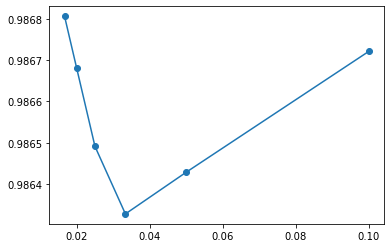

In [43]:
mean_scores = [sum(s)/len(s) for s in scores_list]
plt.plot(learning_rates, mean_scores, '-o')
best_learning_rate = learning_rates[mean_scores.index(max(mean_scores))]
best_estimators = trees[mean_scores.index(max(mean_scores))]
print("best learning rate", best_learning_rate, "best estimators", best_estimators)

In [61]:
optimal_xgboost_params = copy.copy(xgb_gridsearch5.best_params_)
optimal_xgboost_params['learning_rate'] = 0.0167
optimal_xgboost_params['n_estimators'] = 780
optimal_xgboost_params

{'learning_rate': 0.0167,
 'max_depth': 4,
 'max_features': 5,
 'min_sample_leaf': 1,
 'min_sample_split': 1,
 'n_estimators': 780,
 'random_state': 42,
 'subsample': 0.75}

In [ ]:
# optimal model hardcoding 

optimal_xgboost_params = {'learning_rate': 0.0167,
                             'max_depth': 4,
                             'max_features': 5,
                             'min_sample_leaf': 1,
                             'min_sample_split': 1,
                             'n_estimators': 780,
                             'random_state': 42,
                             'subsample': 0.75}


****